# Employee Turn Over - Model training

training process v4
try bayesian opt

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import joblib
import sys

sys.path.append('../../src/')

from modeleval import binary_eval
warnings.filterwarnings("ignore")


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, make_scorer
import shap
from bayes_opt import BayesianOptimization

In [3]:
# !pip install shap
# !pip install bayesian-optimization 

In [4]:
PATH_DATA='../../data/raw/'
PATH_DATA_INTERIM='../../data/interim/'
PATH_MODEL = '../../model/iter1/'
VERS = '4'

model_file = PATH_MODEL+'model_'+VERS+'.pkl'

## Get Data

In [5]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [6]:
## we use 1 as turn over
df1['target'] = (df1.stillExists==False).astype(int)
col_used = list(set(df1.columns)-set(['unique_employee_ids','stillExists','companyAlias','is_train','target']))

col_used.sort() ## --> remember to sort

In [7]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['target']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['target']

In [8]:
Xtrain.shape, Xtest.shape

((3338, 52), (1431, 52))

In [9]:
1-Ytrain.mean(), 1-Ytest.mean()

(0.768424206111444, 0.7721872816212438)

## Transformation

if needed

In [10]:
SS = StandardScaler()
SS.fit(Xtrain)

joblib.dump(SS, PATH_MODEL+'scaler_'+VERS+'.pkl')

['../../model/iter1/scaler_4.pkl']

In [11]:
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

## Model

In [12]:
def targ_func(y_true, y_pred):
    diff = average_precision_score(y_true,y_pred)
    return diff

In [13]:
targ = make_scorer(targ_func, greater_is_better=True)
def loss_target(max_depth,n_estimators,min_samples_split,
                min_samples_leaf,min_impurity_split,X=Xtrain_ss,y=Ytrain):

    md= int(max_depth)
    ne= int(n_estimators)
    mss = int(min_samples_split)
    msl = int(min_samples_leaf)
    mis = max(min_impurity_split,0)
    see= 123

    model_base = RandomForestClassifier(n_estimators= ne, max_depth= md,
                                        min_samples_split = mss,min_samples_leaf = msl,
                                        min_impurity_split = mis,class_weight='balanced_subsample', 
                                        n_jobs = 3, random_state=145)
#     model_base = RandomForestClassifier(random_state=123)
    cv_results = cross_validate(model_base, X, y, cv=5, n_jobs= 3,scoring = targ)
    return cv_results['test_score'].mean()

In [14]:
xgbBO = BayesianOptimization(loss_target, {'max_depth': (15,40),'n_estimators': (100,150),
                                            'min_samples_split': (5, 15),'min_samples_leaf': (5, 15),
                                            'min_impurity_split': (0.05, 0.25)})

xgbBO.maximize(init_points=40, n_iter=15)

|   iter    |  target   | max_depth | min_im... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.5663   |  23.88    |  0.1018   |  12.59    |  13.66    |  139.2    |
|  2        |  0.5135   |  32.58    |  0.1279   |  9.328    |  13.65    |  103.6    |
|  3        |  0.5251   |  39.6     |  0.1298   |  10.99    |  7.104    |  134.9    |
|  4        |  0.5254   |  31.76    |  0.09025  |  10.33    |  12.8     |  143.2    |
|  5        |  0.5111   |  19.33    |  0.1201   |  9.963    |  12.84    |  141.3    |
|  6        |  0.5079   |  16.22    |  0.1541   |  7.151    |  8.384    |  106.8    |
|  7        |  0.5047   |  20.07    |  0.08045  |  6.245    |  11.08    |  125.5    |
|  8        |  0.512    |  34.4     |  0.1582   |  5.507    |  10.9     |  107.7    |
|  9        |  0.5633   |  25.59    |  0.07878  |  14.64    |  10.2     |  109.6    |
|  10       |  0.5777   |  16.5     |  0.203    |  13.

In [16]:
used_param = xgbBO.max['params']
# |  45       |  0.5237   |  16.98    |  0.19     |  7.388    |  13.55    |  106.8    |

# |  47       |  0.5873   |  16.72    |  0.09746  |  15.0     |  15.0     |  148.5    |

In [17]:
used_param['n_jobs'] = 5
used_param['random_state'] = 145
used_param['class_weight'] = 'balanced_subsample'

#     md= int(max_depth)
#     ne= int(n_estimators)
#     mss = int(min_samples_split)
#     msl = int(min_samples_leaf)
for c in ['max_depth','n_estimators','min_samples_split','min_samples_leaf']:
    used_param[c] = int(used_param[c])

In [18]:
tModel = RandomForestClassifier(**used_param)
tModel.fit(Xtrain_ss,Ytrain)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       min_impurity_split=0.09745602911474792,
                       min_samples_leaf=15, min_samples_split=15,
                       n_estimators=148, n_jobs=5, random_state=145)

In [19]:
joblib.dump(tModel, model_file)
tModel_load = joblib.load(model_file)

## Evaluations

In [20]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2565
           1       0.80      0.89      0.84       773

    accuracy                           0.92      3338
   macro avg       0.88      0.91      0.89      3338
weighted avg       0.93      0.92      0.92      3338

aucpr :  0.7343
aucroc :  0.9112


(0.7343, 0.9112)

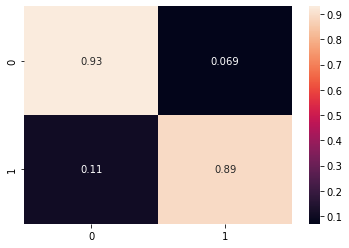

In [21]:
binary_eval(Ytrain, model=tModel_load, predictor=Xtrain_ss)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1105
           1       0.77      0.88      0.82       326

    accuracy                           0.91      1431
   macro avg       0.87      0.90      0.88      1431
weighted avg       0.92      0.91      0.91      1431

aucpr :  0.7046
aucroc :  0.9013


(0.7046, 0.9013)

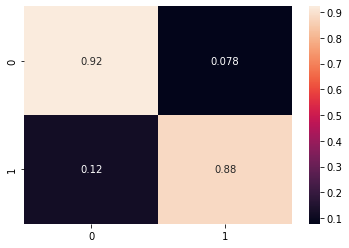

In [22]:
binary_eval(Ytest, model=tModel_load, predictor=Xtest_ss)

## Feature Importance

In [23]:
explainer = shap.TreeExplainer(tModel_load,)
# masker = shap.maskers.Independent(data=Xtest_ss)
# explainer = shap.Explainer(
#     tModel_load, masker=masker, feature_names=Xtest_ss.columns, algorithm="linear"
# )
shap_values = explainer.shap_values(Xtrain_ss)

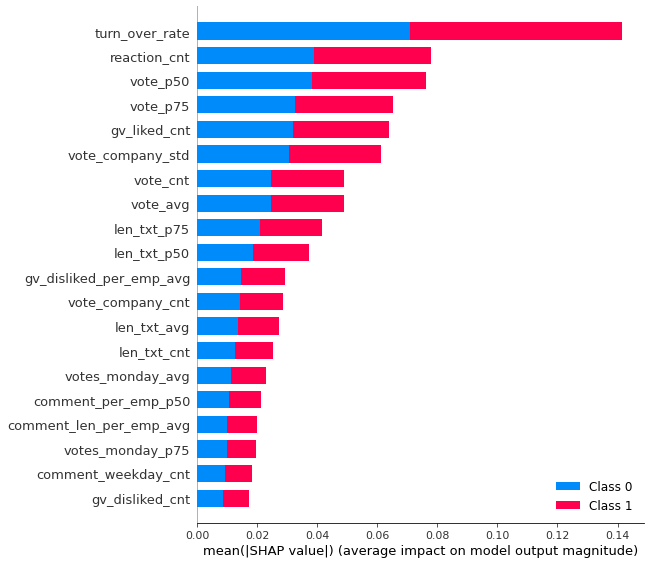

In [24]:
shap.summary_plot(shap_values, features=Xtrain_ss, feature_names=Xtest_ss.columns)

In [25]:
# shap.summary_plot(shap_values, Xtest_ss, plot_type="bar")

In [26]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, Xtest_ss)

In [27]:
# shap.dependence_plot('vote_avg', shap_values, Xtest_ss)

In [28]:
vals = np.abs(shap_values[0]).mean(0)
feature_names = Xtest_ss.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [29]:
feature_importance.to_csv(PATH_MODEL+'feat_importance_'+VERS+'.csv', index = False)

In [30]:
feature_importance.head()

,col_name,feature_importance_vals
31,turn_over_rate,0.070824
30,reaction_cnt,0.038848
39,vote_p50,0.038077
40,vote_p75,0.032657
22,gv_liked_cnt,0.031891
